In [ ]:
#pip install torch

In [ ]:
import torch as th
import numpy as np
import random

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

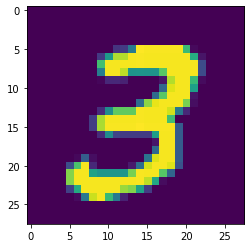

tensor(3)


In [ ]:
#посмотрим на картинки
import matplotlib.pyplot as plt
plt.imshow(X_train[7, :, :])
plt.show()
print(y_train[7])

In [ ]:
#у нас трезмерный тензор, мы хотим двумерный тензор, 
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    self.fc1 = th.nn.Linear(784, 128)
    self.act1 = th.nn.Sigmoid()
    self.fc2 = th.nn.Linear(128,64)
    self.act2 = th.nn.Sigmoid()
    self.fc3 = th.nn.Linear(64,10)
    self.sm = th.nn.Softmax(dim=1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x
  
  def predict(self,x):
    x=self.forward(x)
    x=x.to(device)
    print(x)
    x=self.sm(x)
    return x
net = MNISTnet()

In [ ]:
th.cuda.is_available()

True

In [ ]:
!nvidia-smi

Thu Feb 23 08:31:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)

In [ ]:
loss = th.nn.CrossEntropyLoss()
opt = th.optim.Adam(net.parameters(), lr=0.001)

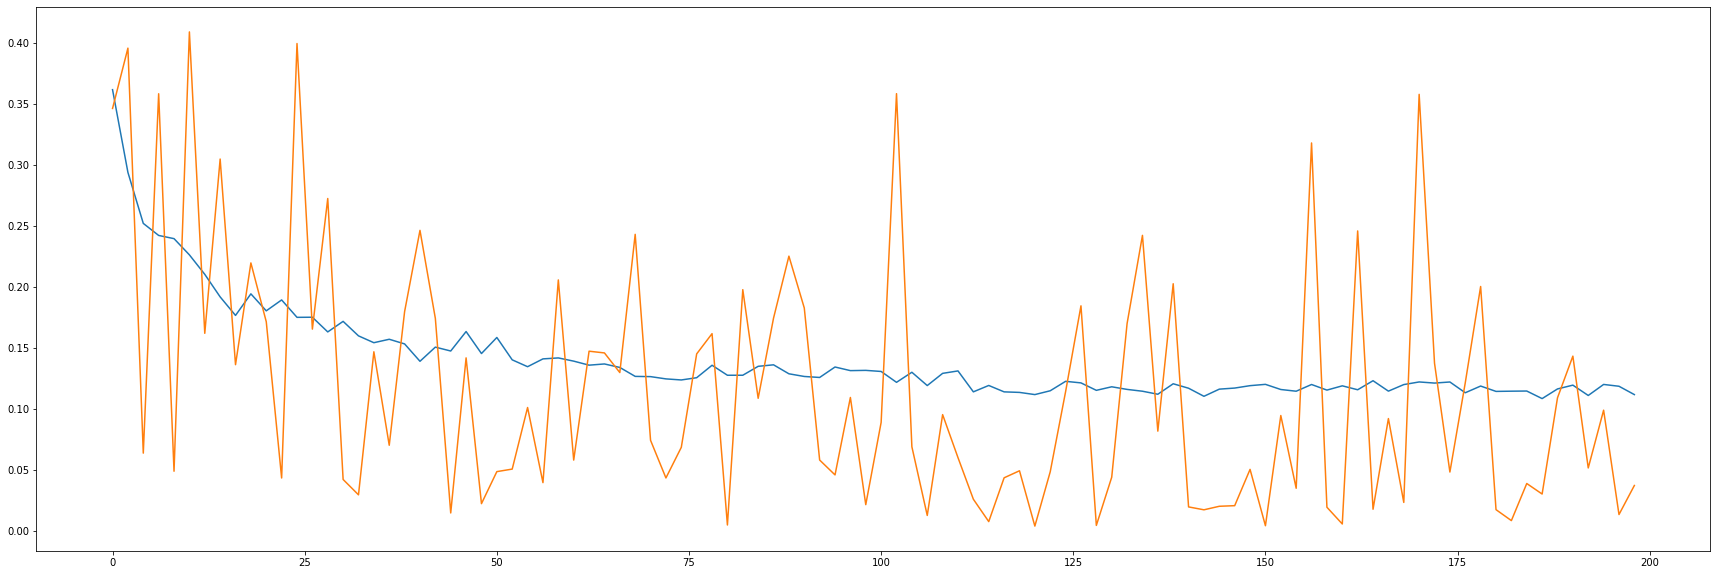

In [ ]:
batch_size = 64
epochs = [40, 100, 200]
X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
fig = plt.figure(figsize=(30, 10))
k = 0
arr_train = []
arr_test = []
epoch_s = []
for epoch in range(200):
  order = np.random.permutation(len(X_train))
  for start_index in range (0, len(X_train), batch_size):
    opt.zero_grad() 
    batch_index = order[start_index:start_index+batch_size]

    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()

    opt.step()
  if epoch % 2 == 0:
    arr_train.append(loss_val)
    test_preds = net.forward(X_test)
    loss_pred = loss(test_preds, y_test) 
    arr_test.append(loss_pred) 
    epoch_s.append(epoch)
    test_preds = test_preds.argmax(dim=1)
for i in range(len(arr_test)):
  arr_test[i] = arr_test[i].cpu().detach().numpy()
  arr_train[i] = arr_train[i].cpu().detach().numpy()
plt.plot(epoch_s, arr_test)
plt.plot(epoch_s, arr_train)
plt.show()

In [ ]:
def pred_test(i): 
  img = X_test[i].view(1, 784) 
  with th.no_grad():
    logps = net.predict(img)
  ps = th.exp(logps)
  probab = list(ps.cpu().numpy()[0])
  print("Predicted Digit =", probab.index(max(probab)))
  print("Current value =", y_test.cpu().numpy()[i])
  plt.subplots(figsize=(6,9))
  plt.imshow(X_test.cpu()[i].resize(1, 28, 28).numpy().squeeze())
  plt.show()

tensor([[ -3.0695,  -2.6526,   2.7839,   2.6775, -12.2989,  -1.8788, -11.3046,
          -1.6849,  -5.2796,  -5.8974]], device='cuda:0')
Predicted Digit = 2
Current value = 3


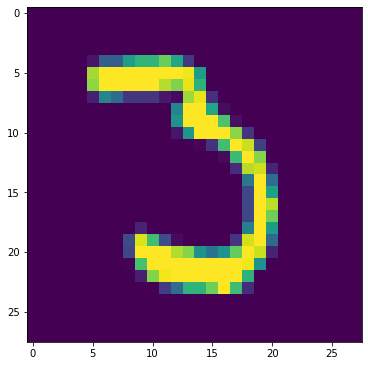

In [ ]:
pred_test(158)

In [ ]:
preds = net.predict(X_test)
true_vals, all_vals = 0, 0
for i in range(10000):
  probab = list(preds.cpu().detach().numpy()[i])
  if probab.index(max(probab)) == y_test.cpu().numpy()[i]:
    true_vals += 1
  else: 
    print(i, end=" ")
  all_vals += 1

print("\nNumber Of Images Tested =", all_vals)
print("Model Accuracy =", (true_vals/all_vals))

tensor([[ -9.1369,  -8.6230,  -1.2576,  ...,  10.0660,  -6.4902,  -2.1598],
        [-10.1913,  -2.2007,   4.9757,  ...,  -5.1493,  -5.7511, -12.7523],
        [-15.8267,   9.2288,  -1.0554,  ...,  -1.8800,  -4.5389,  -8.4442],
        ...,
        [-12.6822,  -6.9349,  -7.1041,  ...,  -2.1369,  -3.9008,  -0.7519],
        [ -5.3037,  -6.6266,  -6.3190,  ...,  -7.7280,   1.1094, -13.5353],
        [ -6.3303, -10.0285,  -4.3514,  ...,  -8.8135,  -4.0381,  -3.2842]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
8 18 158 193 217 247 259 264 321 340 381 421 445 495 543 551 565 591 619 659 684 717 720 740 844 846 900 924 938 951 965 1014 1039 1044 1062 1124 1181 1226 1232 1247 1260 1270 1289 1299 1319 1328 1364 1458 1469 1522 1525 1527 1530 1549 1553 1570 1609 1611 1669 1678 1681 1709 1717 1730 1751 1754 1790 1828 1871 1878 1901 1909 1940 1955 1970 1982 1984 2004 2016 2018 2024 2043 2053 2070 2098 2109 2118 2130 2135 2182 2224 2232 2266 2272 2291 2293 2299 2382 2387 2393 2406 2414 2422